## 图像定位（Image localization）

## 基础知识

**常见图像处理任务**
1. 图像分类（Image classification）：给定一张图像，判断图像中包含的物体类别。
2. 图像定位（Image localization）：给定一张图像，不仅要判断图像中包含的物体类别，还要给出物体在图像中的位置。
3. 图像语义分割（Image segmentation）：给定一张图像，不仅要判断图像中包含的物体类别，还要给出物体在图像中的位置，并进一步分割出物体在图像中的具体区域。
4. 图像目标检测（Object localization）：给定一张图像，判断图像中包含的物体类别，并给出物体在图像中的位置。
5. 图像实例分割（Instance segmentation）：给定一张图像，判断图像中包含的物体类别，并给出物体在图像中的位置，并进一步分割出物体在图像中的具体区域，同时区分出不同物体的具体区域。

**图像定位**
对于单纯的分类问题，我们只需要将图像输入到神经网络中，然后通过神经网络输出得到图像中物体的类别。然而，对于图像定位问题，我们不仅需要判断图像中物体的类别，还需要给出物体在图像中的位置，输出四个数字（x, y, w, h），图像中某一点的坐标（x, y），以及图像的宽度和高度，这样我们可以很容易的找到物体的边框。因此，我们需要在神经网络中引入定位信息，以确定物体在图像中的位置。


## 导入库

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision
from torchvision import transforms
import os

from lxml import etree              # conda install lxml
from matplotlib.patches import Rectangle
import glob

from PIL import Image

## 观察和理解数据

(400, 600, 3)


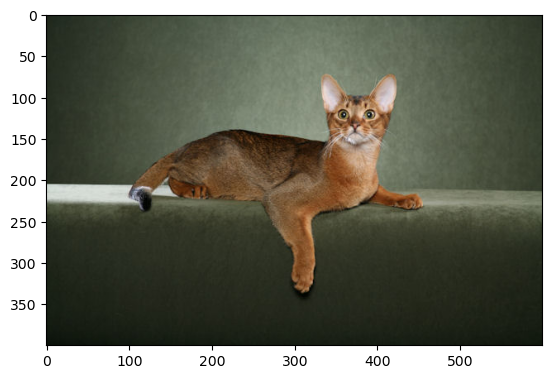

In [2]:
# 读取第一张图片
pil_img = Image.open(r'./dataset/Oxford-IIIT Pets Dataset/images/Abyssinian_1.jpg')
np_img = np.array(pil_img)
print(np_img.shape)

plt.imshow(np_img)
plt.show()

In [3]:
# 读取第一张图片的xml文件
xml = open(r'./dataset/Oxford-IIIT Pets Dataset/annotations/xmls/Abyssinian_1.xml').read()
selection = etree.HTML(xml)

# 获取图像的尺寸
width = selection.xpath('//size/width/text()')[0]
height = selection.xpath('//size/height/text()')[0]
width, height


('600', '400')

In [4]:
# 获取图像中猫头的位置
xmin = selection.xpath('//bndbox/xmin/text()')[0]
ymin = selection.xpath('//bndbox/ymin/text()')[0]
xmax = selection.xpath('//bndbox/xmax/text()')[0]
ymax = selection.xpath('//bndbox/ymax/text()')[0]
xmin, ymin, xmax, ymax

('333', '72', '425', '158')

In [5]:
# 将str转换为int
width = int(width)
height = int(height)

xmin = int(xmin)
ymin = int(ymin)
xmax = int(xmax)
ymax = int(ymax)

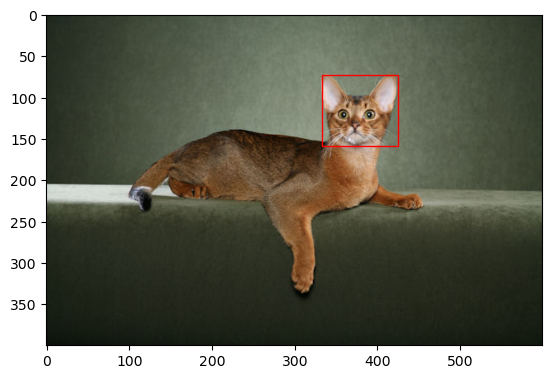

In [6]:
# 绘制图片及猫头的位置边框
plt.imshow(np_img)
rectangle = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, color='red')       # 实例化矩形框
axis = plt.gca()                    # 获取当前坐标轴，get current axis
axis.axes.add_patch(rectangle)      # 在坐标轴中添加矩形框
plt.show()

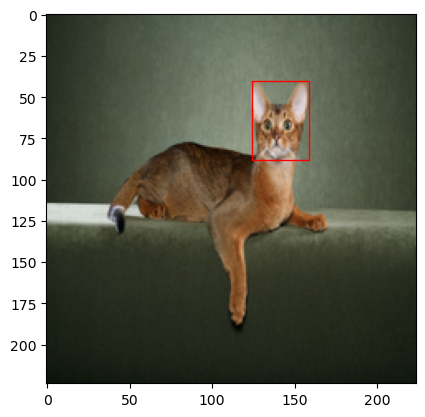

In [7]:
# 图像resize后，定位框位置的确定
resize_pil_img = pil_img.resize((224, 224))

# 定位框按缩放比例同步缩放
xmin = xmin*224/width
ymin = ymin*224/height
xmax = xmax*224/width
ymax = ymax*224/height

# 绘制图片及猫头的位置边框
plt.imshow(resize_pil_img)
rectangle = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, color='red')       # 实例化矩形框
axis = plt.gca()                    # 获取当前坐标轴，get current axis
axis.axes.add_patch(rectangle)      # 在坐标轴中添加矩形框
plt.show()

## 创建输入数据集

In [8]:
# 获取所有图片的路径
all_imgs_path = glob.glob('./dataset/Oxford-IIIT Pets Dataset/images/*.jpg')
print("Length: ", len(all_imgs_path))
all_imgs_path[:5]

Length:  7390


['./dataset/Oxford-IIIT Pets Dataset/images\\Abyssinian_1.jpg',
 './dataset/Oxford-IIIT Pets Dataset/images\\Abyssinian_10.jpg',
 './dataset/Oxford-IIIT Pets Dataset/images\\Abyssinian_100.jpg',
 './dataset/Oxford-IIIT Pets Dataset/images\\Abyssinian_101.jpg',
 './dataset/Oxford-IIIT Pets Dataset/images\\Abyssinian_102.jpg']

In [9]:
# 获取所有xml文件的路径
all_xmls_path = glob.glob('./dataset/Oxford-IIIT Pets Dataset/annotations/xmls/*.xml')
print("Length: ", len(all_xmls_path))
all_xmls_path[:5]

Length:  3686


['./dataset/Oxford-IIIT Pets Dataset/annotations/xmls\\Abyssinian_1.xml',
 './dataset/Oxford-IIIT Pets Dataset/annotations/xmls\\Abyssinian_10.xml',
 './dataset/Oxford-IIIT Pets Dataset/annotations/xmls\\Abyssinian_100.xml',
 './dataset/Oxford-IIIT Pets Dataset/annotations/xmls\\Abyssinian_101.xml',
 './dataset/Oxford-IIIT Pets Dataset/annotations/xmls\\Abyssinian_102.xml']

In [10]:
# 使用xml文件名删选进行标注的图片
# 分离xml文件名
xmls_names = [x.split('\\')[-1].split('.xml')[0] for x in all_xmls_path]
# 例如：'./dataset/Oxford-IIIT Pets Dataset/annotations/xmls\\Abyssinian_1.xml' -> 'Abyssinian_1'
print("xmls_names Length: ", len(xmls_names))
xmls_names[:5]

xmls_names Length:  3686


['Abyssinian_1',
 'Abyssinian_10',
 'Abyssinian_100',
 'Abyssinian_101',
 'Abyssinian_102']

In [11]:
# 删选有标注的图片
xmls_imgs_path = [img for img in all_imgs_path 
        if img.split('\\')[-1].split('.jpg')[0] in xmls_names]
# 例如：'./dataset/Oxford-IIIT Pets Dataset/images\\Abyssinian_1.jpg' -> 'Abyssinian_1' 得到的 'Abyssinian_1' 在 xmls_names 中，则保留
print("xmls_names Length: ", len(xmls_names))
print("xmls_imgs_path Length: ", len(xmls_imgs_path))
xmls_imgs_path[:5], xmls_names[:5]

xmls_names Length:  3686
xmls_imgs_path Length:  3686


(['./dataset/Oxford-IIIT Pets Dataset/images\\Abyssinian_1.jpg',
  './dataset/Oxford-IIIT Pets Dataset/images\\Abyssinian_10.jpg',
  './dataset/Oxford-IIIT Pets Dataset/images\\Abyssinian_100.jpg',
  './dataset/Oxford-IIIT Pets Dataset/images\\Abyssinian_101.jpg',
  './dataset/Oxford-IIIT Pets Dataset/images\\Abyssinian_102.jpg'],
 ['Abyssinian_1',
  'Abyssinian_10',
  'Abyssinian_100',
  'Abyssinian_101',
  'Abyssinian_102'])

In [12]:
# 从xml文件中解析出标注信息，转化为比例格式，便于图像resize后，定位框位置的确定
def xml_to_label(path):
    xml = open(r'{}'.format(path)).read()
    selection = etree.HTML(xml)
    width = int(selection.xpath('//size/width/text()')[0])
    height = int(selection.xpath('//size/height/text()')[0])
    xmin = int(selection.xpath('//bndbox/xmin/text()')[0])
    ymin = int(selection.xpath('//bndbox/ymin/text()')[0])
    xmax = int(selection.xpath('//bndbox/xmax/text()')[0])
    ymax = int(selection.xpath('//bndbox/ymax/text()')[0])
    return [xmin/width, ymin/height, xmax/width, ymax/height]

In [ ]:
labels = [xml_to_label(path) for path in all_xmls_path]
out1_label, out2_label, out3_label, out4_label = list(zip(*labels))

In [ ]:
len(out1_label), len(out2_label), len(out3_label), len(out4_label)

(3686, 3686, 3686, 3686)

In [ ]:
index = np.random.permutation(len(imgs))

In [ ]:
images = np.array(imgs)[index]
#labels = labels[index]

In [ ]:
out1_label = np.array(out1_label).astype(np.float32).reshape(-1, 1)[index]
out2_label = np.array(out2_label).astype(np.float32).reshape(-1, 1)[index]
out3_label = np.array(out3_label).astype(np.float32).reshape(-1, 1)[index]
out4_label = np.array(out4_label).astype(np.float32).reshape(-1, 1)[index]

In [ ]:
i = int(len(imgs)*0.8)

In [ ]:
train_images = images[:i]
out1_train_label = out1_label[:i]
out2_train_label = out2_label[:i]
out3_train_label = out3_label[:i]
out4_train_label = out4_label[:i]

test_images = images[i: ]
out1_test_label = out1_label[i: ]
out2_test_label = out2_label[i: ]
out3_test_label = out3_label[i: ]
out4_test_label = out4_label[i: ]

In [ ]:
transform = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
])

In [ ]:
class Oxford_dataset(data.Dataset):
    def __init__(self, img_paths, out1_label, out2_label, 
                       out3_label, out4_label, transform):
        self.imgs = img_paths
        self.out1_label = out1_label
        self.out2_label = out2_label
        self.out3_label = out3_label
        self.out4_label = out4_label
        self.transforms = transform
        
    def __getitem__(self, index):
        img = self.imgs[index]
        out1_label = self.out1_label[index]
        out2_label = self.out2_label[index]
        out3_label = self.out3_label[index]
        out4_label = self.out4_label[index]
        pil_img = Image.open(img) 
        imgs_data = np.asarray(pil_img, dtype=np.uint8)
        if len(imgs_data.shape) == 2:
            imgs_data = np.repeat(imgs_data[:, :, np.newaxis], 3, axis=2)
            img_tensor = self.transforms(Image.fromarray(imgs_data))
        else:
            img_tensor = self.transforms(pil_img)
        return (img_tensor, 
                out1_label, 
                out2_label, 
                out3_label, 
                out4_label)
    
    def __len__(self):
        return len(self.imgs)

In [ ]:
train_dataset = Oxford_dataset(train_images, out1_train_label, 
                               out2_train_label, out3_train_label,
                               out4_train_label, transform)

In [ ]:
test_dataset = Oxford_dataset(test_images, out1_test_label, 
                               out2_test_label, out3_test_label,
                               out4_test_label, transform)

In [ ]:
BATCH_SIZE = 16

train_dl = data.DataLoader(
                      train_dataset,
                      batch_size=BATCH_SIZE,
                      shuffle=True,
)

In [ ]:
test_dl = data.DataLoader(
                      test_dataset,
                      batch_size=BATCH_SIZE,
)

In [ ]:
(imgs_batch, 
out1_batch, 
out2_batch, 
out3_batch, 
out4_batch) = next(iter(train_dl))

In [ ]:
imgs_batch.shape, out1_batch.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 1]))

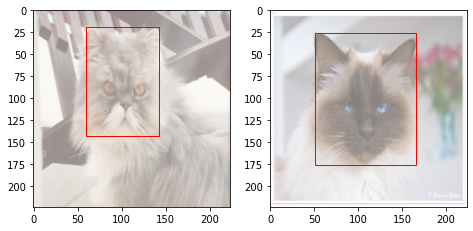

In [ ]:
plt.figure(figsize=(12, 8))
for i,(img, label1, label2,
            label3,label4,) in enumerate(zip(imgs_batch[:2],
                                             out1_batch[:2], 
                                             out2_batch[:2], 
                                             out3_batch[:2], 
                                             out4_batch[:2])):
    img = (img.permute(1,2,0).numpy() + 1)/2
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    xmin, ymin, xmax, ymax = label1*224, label2*224, label3*224, label4*224, 
    rect = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, color='red')
    ax = plt.gca()
    ax.axes.add_patch(rect)

# 创建定位模型

In [ ]:
resnet = torchvision.models.resnet101(pretrained=True)

In [ ]:
in_f = resnet.fc.in_features
print(in_f)

2048


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_base = nn.Sequential(*list(resnet.children())[:-1])
        self.fc1 = nn.Linear(in_f, 1)
        self.fc2 = nn.Linear(in_f, 1)
        self.fc3 = nn.Linear(in_f, 1)
        self.fc4 = nn.Linear(in_f, 1)

    def forward(self, x):
        x = self.conv_base(x)
        x = x.view(x.size(0), -1)
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        x3 = self.fc3(x)
        x4 = self.fc4(x)
        return x1, x2, x3, x4 

In [ ]:
model = Net()

In [ ]:
if torch.cuda.is_available():
    model.to('cuda')

In [ ]:
loss_fn = nn.MSELoss()

In [ ]:
from torch.optim import lr_scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
def fit(epoch, model, trainloader, testloader):
    total = 0
    running_loss = 0
    
    model.train()
    for x, y1, y2, y3, y4 in trainloader:
        if torch.cuda.is_available():
            x, y1, y2, y3, y4 = (x.to('cuda'), 
                                 y1.to('cuda'), y2.to('cuda'),
                                 y3.to('cuda'), y4.to('cuda'))       
        y_pred1, y_pred2, y_pred3, y_pred4 = model(x)
        
        loss1 = loss_fn(y_pred1, y1)
        loss2 = loss_fn(y_pred2, y2)
        loss3 = loss_fn(y_pred3, y3)
        loss4 = loss_fn(y_pred4, y4)
        loss = loss1 + loss2 + loss3 + loss4
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            running_loss += loss.item()
    exp_lr_scheduler.step()
    epoch_loss = running_loss / len(trainloader.dataset)
        
        
    test_total = 0
    test_running_loss = 0 
    
    model.eval()
    with torch.no_grad():
        for x, y1, y2, y3, y4 in testloader:
            if torch.cuda.is_available():
                x, y1, y2, y3, y4 = (x.to('cuda'), 
                                     y1.to('cuda'), y2.to('cuda'),
                                     y3.to('cuda'), y4.to('cuda'))
            y_pred1, y_pred2, y_pred3, y_pred4 = model(x)
            loss1 = loss_fn(y_pred1, y1)
            loss2 = loss_fn(y_pred2, y2)
            loss3 = loss_fn(y_pred3, y3)
            loss4 = loss_fn(y_pred4, y4)
            loss = loss1 + loss2 + loss3 + loss4
            test_running_loss += loss.item()
            
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    
        
    print('epoch: ', epoch, 
          'loss： ', round(epoch_loss, 3),
          'test_loss： ', round(epoch_test_loss, 3),
             )
        
    return epoch_loss, epoch_test_loss

In [ ]:
epochs = 10

In [ ]:
train_loss = []
test_loss = []

for epoch in range(epochs):
    epoch_loss, epoch_test_loss = fit(epoch, model, train_dl, test_dl)
    train_loss.append(epoch_loss)
    test_loss.append(epoch_test_loss)

epoch:  0 loss：  0.006 test_loss：  0.002
epoch:  1 loss：  0.001 test_loss：  0.001
epoch:  2 loss：  0.001 test_loss：  0.001
epoch:  3 loss：  0.0 test_loss：  0.001
epoch:  4 loss：  0.0 test_loss：  0.0
epoch:  5 loss：  0.0 test_loss：  0.001
epoch:  6 loss：  0.0 test_loss：  0.0
epoch:  7 loss：  0.0 test_loss：  0.0
epoch:  8 loss：  0.0 test_loss：  0.0
epoch:  9 loss：  0.0 test_loss：  0.0


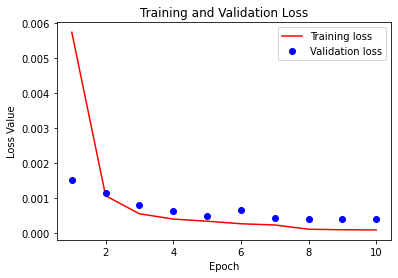

In [ ]:
plt.figure()
plt.plot(range(1, len(train_loss)+1), train_loss, 'r', label='Training loss')
plt.plot(range(1, len(train_loss)+1), test_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

# 模型保存

In [ ]:
PATH = 'location_model.pth'

In [ ]:
torch.save(model.state_dict(), PATH)

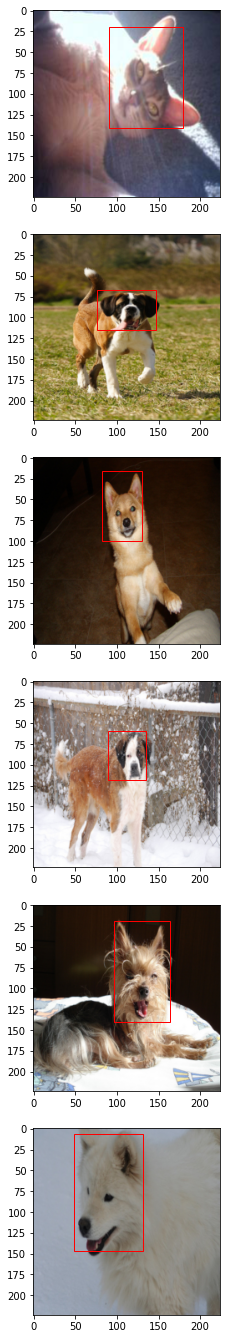

In [ ]:
plt.figure(figsize=(8, 24))
imgs, _, _, _, _ = next(iter(test_dl))
imgs = imgs.to('cuda')
out1, out2, out3, out4 = model(imgs)
for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.imshow(imgs[i].permute(1,2,0).cpu().numpy())
    xmin, ymin, xmax, ymax = (out1[i].item()*224, 
                              out2[i].item()*224, 
                              out3[i].item()*224, 
                              out4[i].item()*224)
    rect = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, color='red')
    ax = plt.gca()
    ax.axes.add_patch(rect)